# Quality Control using DR

- In this notebook, we will use the depolarization ratio to quality control a volume of data from the new radar at Radisson, Saskatchewan
- We will also visualize the data using some openly-available colour tables.
- This notebook was originally prepared using material subsequently published in https://doi.org/10.1002/met.1929

## retrieve data from s3 bucket

In [1]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/erad2024/baltrad/baltrad_short_course/"
!mkdir -p data
files = [
    "2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5",
    "hawaii.txt",
    "moleron.txt",
    "oleron.txt",
    "mroma.txt",
    "vik.txt",
]
for file in files:
    file0 = os.path.join(path, file)
    name = os.path.join("data", Path(file).name)
    if not os.path.exists(name):
        print(f"downloading, {name}")
        urllib.request.urlretrieve(f"{URL}{file0}", name)

downloading, data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5


downloading, data/hawaii.txt
downloading, data/moleron.txt


downloading, data/oleron.txt


downloading, data/mroma.txt


downloading, data/vik.txt


In [2]:
import _raveio
import ropo_realtime, ec_drqc
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import GmapColorMap

### Block of look-ups for display

In [3]:
PALETTE = {}  # To be populated

UNDETECT = {
    "TH": GmapColorMap.PUREWHITE,
    "DBZH": GmapColorMap.PUREWHITE,
    "DR": GmapColorMap.PUREWHITE,
    "VRADH": GmapColorMap.GREY5,
    "RHOHV": GmapColorMap.PUREWHITE,
    "ZDR": GmapColorMap.PUREWHITE,
}

NODATA = {
    "TH": GmapColorMap.WEBSAFEGREY,
    "DBZH": GmapColorMap.WEBSAFEGREY,
    "DR": GmapColorMap.WEBSAFEGREY,
    "VRADH": GmapColorMap.GREY8,
    "RHOHV": GmapColorMap.WEBSAFEGREY,
    "ZDR": GmapColorMap.WEBSAFEGREY,
}

LEGEND = {
    "TH": "Radar reflectivity factor (dBZ)",
    "DBZH": "Radar reflectivity factor (dBZ)",
    "DR": "Depolarization ratio (dB)",
    "VRADH": "Radial wind velocity away from radar (m/s)",
    "RHOHV": "Cross-polar correlation coefficient",
    "ZDR": "Differential reflectivity (dB)",
}

TICKS = {
    "TH": range(-30, 80, 10),
    "DBZH": range(-30, 80, 10),
    "ZDR": range(-8, 9, 2),
    "RHOHV": np.arange(0, 11, 1) / 10.0,
    "VRADH": range(-48, 56, 8),
    "DR": range(-36, 3, 3),
}

### Colormap loader and loads

In [4]:
def loadPal(fstr, reverse=True):
    fd = open(fstr)
    LINES = fd.readlines()
    fd.close()
    pal = []
    for line in LINES:
        s = line.split()
        if reverse:
            s.reverse()
        for val in s:
            pal.append(int(float(val) * 255))
    if reverse:
        pal.reverse()
    return pal


# Colour maps by Fabio Crameri, http://www.fabiocrameri.ch/colourmaps.php, a couple of them modified
# Todo: maybe use new cmweather colormaps
PALETTE["DBZH"] = loadPal("data/hawaii.txt")
PALETTE["DR"] = loadPal("data/moleron.txt", False)  # Modified oleron
PALETTE["ZDR"] = loadPal("data/oleron.txt", False)
PALETTE["RHOHV"] = loadPal("data/mroma.txt")  # Modified roma
PALETTE["VRADH"] = loadPal("data/vik.txt", False)

### Set up the display

In [5]:
def plot(obj):
    fig = plt.figure()
    default_size = fig.get_size_inches()
    fig.set_size_inches((default_size[0] * 2, default_size[1] * 2))

    paramname = obj.getParameterNames()[0]
    pal = PALETTE[paramname]
    pal[0], pal[1], pal[2] = UNDETECT[
        paramname
    ]  # Special value - areas radiated but void of echo
    pal[767], pal[766], pal[765] = NODATA[paramname]  # Special value - areas unradiated
    if paramname == "VRADH":
        pal[379], pal[380], pal[381] = GmapColorMap.PUREWHITE  # VRADH isodop
        pal[382], pal[383], pal[384] = GmapColorMap.PUREWHITE  # VRADH isodop
        pal[385], pal[386], pal[387] = GmapColorMap.PUREWHITE  # VRADH isodop
    colorlist = []
    for i in range(0, len(pal), 3):
        colorlist.append([pal[i] / 255.0, pal[i + 1] / 255.0, pal[i + 2] / 255.0])

    param = obj.getParameter(paramname)
    data = param.getData()
    data = data * param.gain + param.offset

    im = plt.imshow(data, cmap=matplotlib.colors.ListedColormap(colorlist))
    cax = plt.gca()
    cax.axes.get_xaxis().set_visible(False)
    cax.axes.get_yaxis().set_visible(False)

    cb = plt.colorbar(ticks=TICKS[paramname])
    cb.set_label(LEGEND[paramname])

    plt.show()

## Do the science
### Read the polar volume, QC the reflectivity using legacy ROPO, and then save the QC:ed result

In [6]:
rio = _raveio.open("data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5")
rio.object = ropo_realtime.generate(rio.object)
rio.save("data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.ropo.h5")

### Re-read the polar volume, QC it using depolarization ratio, and then save the QC:ed result

In [7]:
rio = _raveio.open("data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5")
pvol = rio.object
ec_drqc.drQC(pvol)
rio.object = pvol
rio.save("data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.drqc.h5")

### Create, read and display CAPPIs, starting with Doppler-corrected reflectivity

In [8]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5" -o data/cappi_DBZH.h5 -s 1000 -T -M

--- Logging error ---


Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp", line 240, in <module>

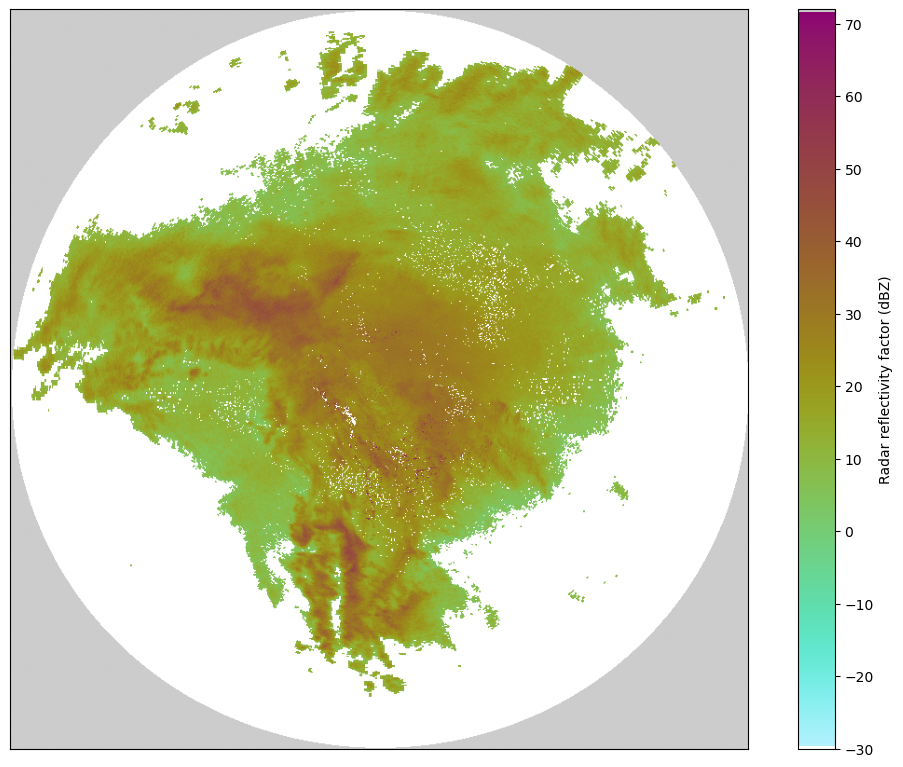

In [9]:
cappi = _raveio.open("data/cappi_DBZH.h5").object
plot(cappi)

### Differential reflectivity

In [10]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5" -o data/cappi_ZDR.h5 -s 1000.0 -T -M -q ZDR -g 0.0629921 -O -8.0

--- Logging error ---
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp",

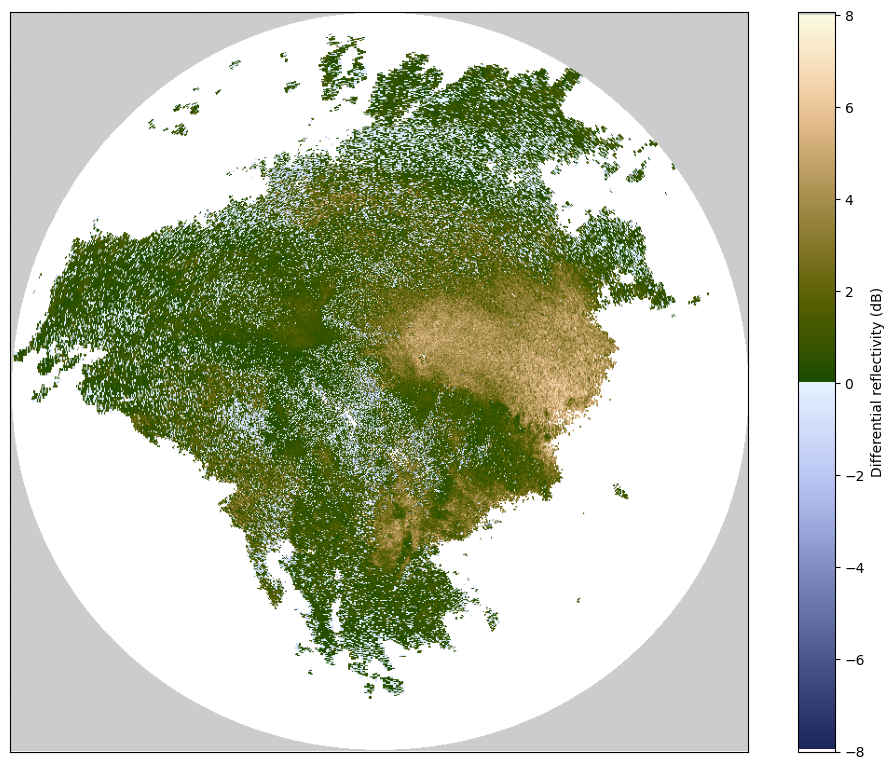

In [11]:
cappi = _raveio.open("data/cappi_ZDR.h5").object
plot(cappi)

### Cross-polar correlation coefficient

In [12]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5" -o data/cappi_RHOHV.h5 -s 1000.0 -T -M -q RHOHV -g 0.00393701 -O 0.0

--- Logging error ---
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp",

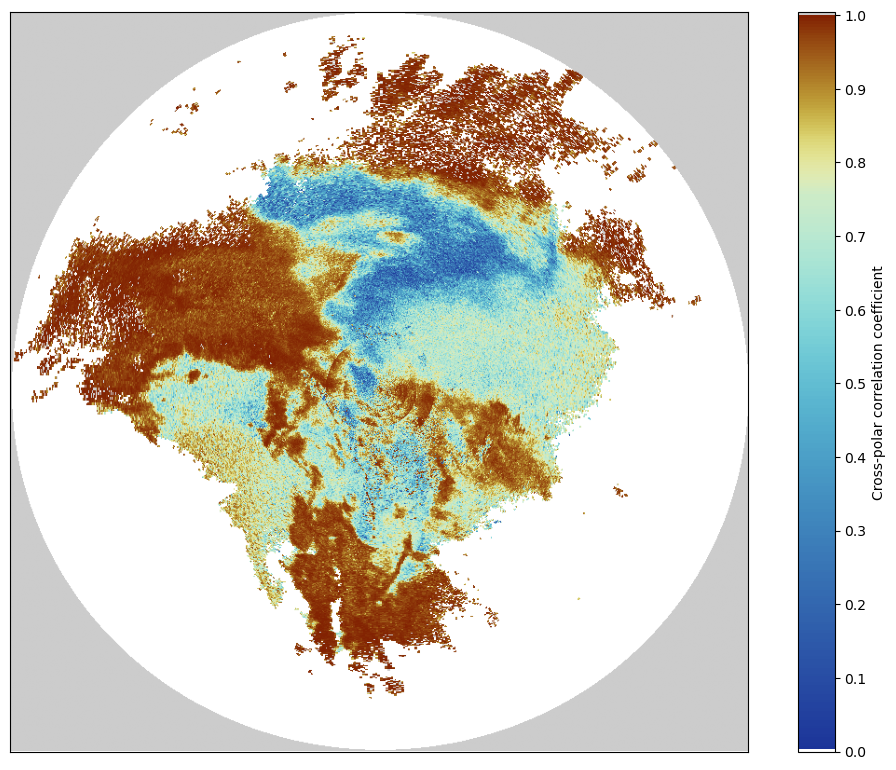

In [13]:
cappi = _raveio.open("data/cappi_RHOHV.h5").object
plot(cappi)

### Radial wind velocity, lowest PPI

In [14]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.16.h5" -o data/ppi_VRADH.h5 -s 1000.0 -T -M -q VRADH -g 0.37716537714004517 -O -48. -p PPI -P 0.4

--- Logging error ---
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp",

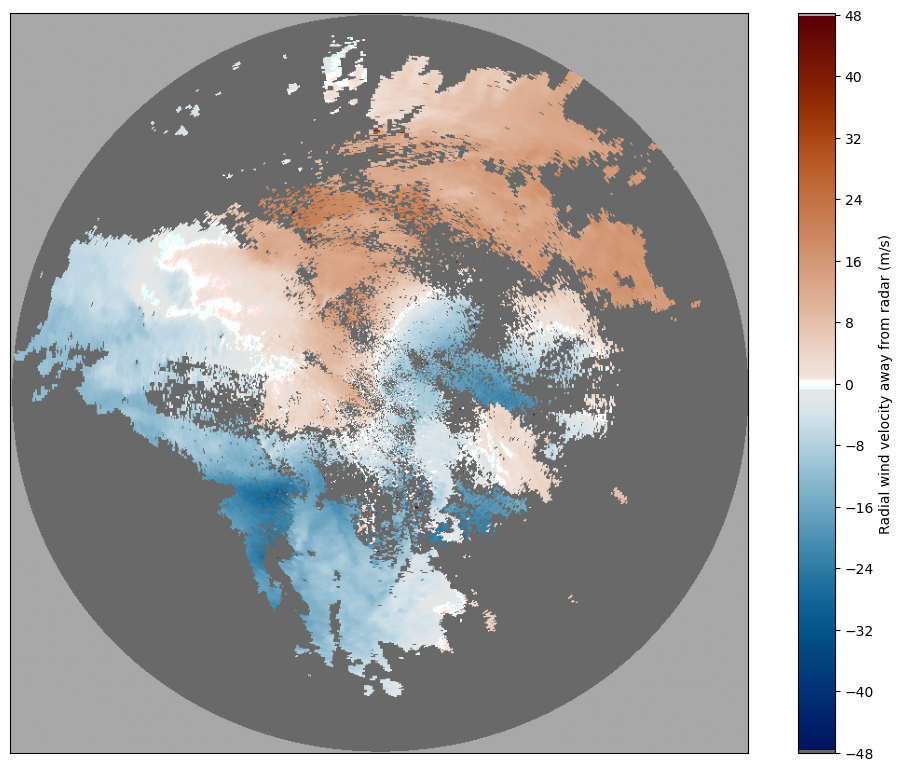

In [15]:
ppi = _raveio.open("data/ppi_VRADH.h5").object
plot(ppi)

### Depolarization ratio

In [16]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.drqc.h5" -o data/cappi_DR.h5 -s 1000 -T -M -q DR -g 0.129951 -O -33.1376

--- Logging error ---
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp",

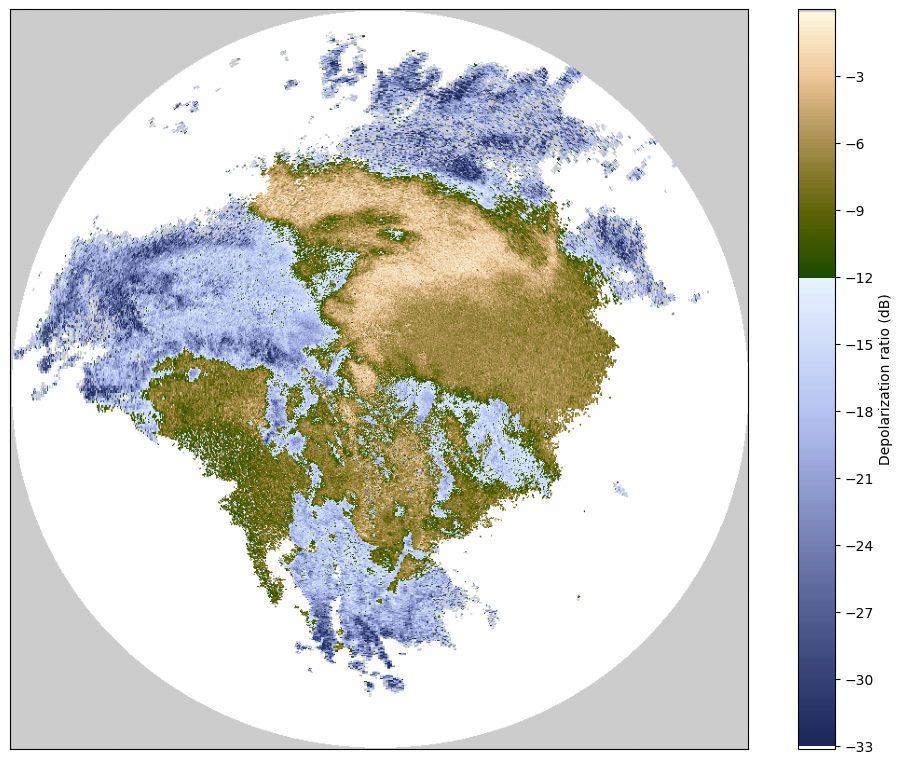

In [17]:
cappi = _raveio.open("data/cappi_DR.h5").object
plot(cappi)

### ROPO:ed reflectivity

In [18]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.ropo.h5" -o data/cappi_DBZH_ropo.h5 -s 1000 -T -M

--- Logging error ---
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp",

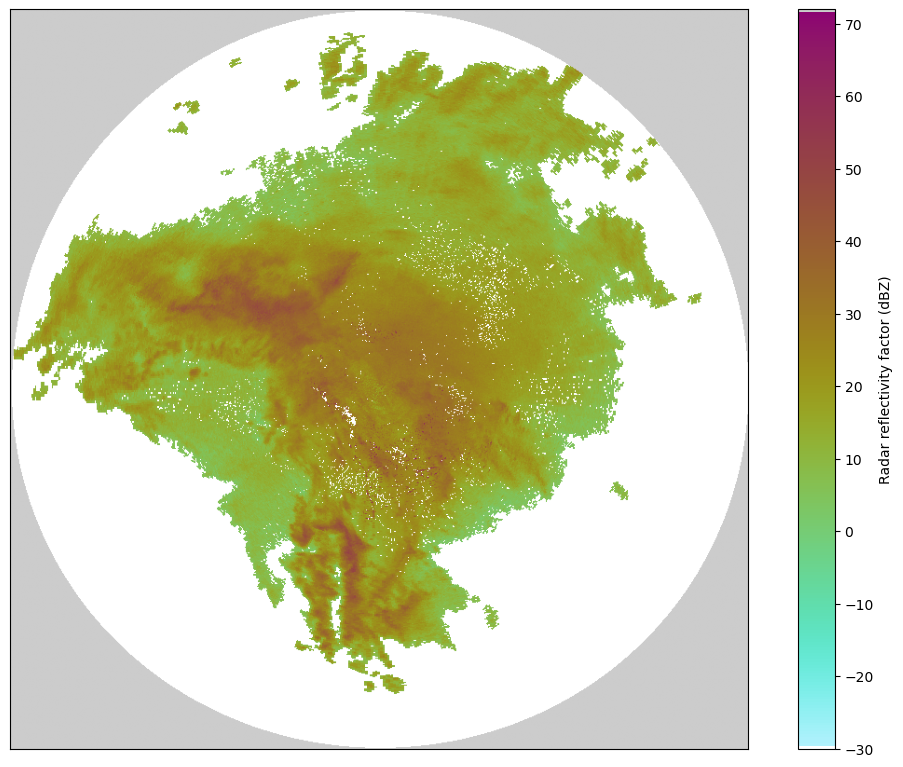

In [19]:
cappi = _raveio.open("data/cappi_DBZH_ropo.h5").object
plot(cappi)

### DRQC:ed reflectivity

In [20]:
!radarcomp -i "data/2019051509_00_ODIMH5_PVOL6S_VOL_casra.drqc.h5" -o data/cappi_DBZH_drqc.h5 -s 1000 -T -M

--- Logging error ---
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1000, in emit
    self.socket.send(msg)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 875, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 1003, in emit
    self._connect_unixsocket(self.address)
  File "/srv/conda/envs/notebook/lib/python3.11/logging/handlers.py", line 886, in _connect_unixsocket
    self.socket.connect(address)
FileNotFoundError: [Errno 2] No such file or directory
Call stack:
  File "/srv/conda/envs/notebook/rave/bin/radarcomp",

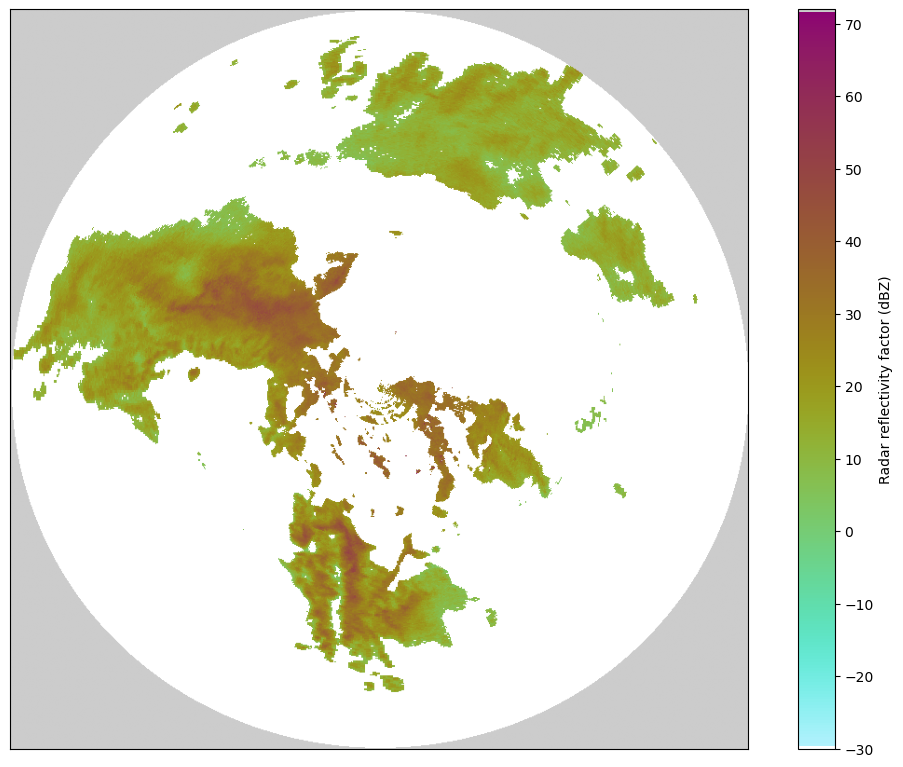

In [21]:
cappi = _raveio.open("data/cappi_DBZH_drqc.h5").object
plot(cappi)